# Example: Polynomial Cureve Fitting

Observse a real-valued input variable $x$ $\rightarrow$ predict a real-valued target variable $t$ 

* $\textbf{x} \equiv (x_1, \cdots, x_i, \cdots, x_N)^T, \quad x_i \in [0, 1]$
* $\textbf{t} \equiv (t_1, \cdots, t_i, \cdots, t_N)^T, \quad t_i = \sin(2\pi x_i)$

In [1]:
import numpy as np
import matplotlib.pylab as plt

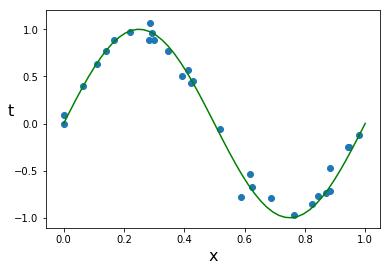

In [2]:
# making data
seed = 23
np.random.seed(seed)
N = 30
x = np.random.rand(N)
t = np.sin(2*np.pi*x) + np.random.randn(N) * 0.1
x_sin = np.linspace(0, 1)
t_sin = np.sin(2*np.pi*x_sin)
plt.plot(x_sin, t_sin, c='green')
plt.scatter(x, t)
plt.xlabel('x', fontsize=16)
plt.ylabel('t', rotation=0, fontsize=16)
plt.show()

* Goal: exploit this training set in order to make predictions of the value $\hat{t}$ of the target variable for some new value $\hat{x}$ of the input variable.
* Use some theories:
    * Probability theory: provides a framework for expressing such uncertainty in a precise and quantitative manner
    * Decision theory: allows us to exploit this probabilistic representation in order to make predictions that are optimal according to appropriate criteria
* For the moment, let's use polynomial function, where $M$ is the order of polynomial. $y(x, \mathbf{w})$ is a linear function of coefficients ($\mathbf{w}$)

$$y(x, \mathbf{w}) = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M = \sum_{j=0}^{M} w_j x^j$$

In [3]:
from numpy.polynomial import polynomial as P

In [4]:
def vandermonde_matrix(x, m):
    return np.array([x**i for i in range(m+1)]).T

In [5]:
def polynomial_function(x, w, m):
    assert w.size == m+1, "coefficients number must same as M"
    V = vandermonde_matrix(x, m)  # shape (M, x.size)
    return np.dot(V, w)

In [6]:
M = 3
w = np.random.randn(M+1)
t_hat = polynomial_function(x, w, M)
t_hat

array([ 0.26547517, -1.04686006, -0.31361225,  0.48607581,  0.5073796 ,
       -0.08125013,  0.51723693,  0.41402373,  0.08137259,  0.39594907,
        0.51245958, -0.75852863, -0.76245207,  0.47747047,  0.13987216,
       -1.20562748, -0.59876596,  0.51884313,  0.4803002 ,  0.48355111,
       -0.51219063,  0.06367656,  0.52042083,  0.51220686, -1.02352958,
        0.51948553,  0.38632607,  0.44999819, -0.69846426,  0.3790729 ])

In [7]:
P.polyval(x, w)

array([ 0.26547517, -1.04686006, -0.31361225,  0.48607581,  0.5073796 ,
       -0.08125013,  0.51723693,  0.41402373,  0.08137259,  0.39594907,
        0.51245958, -0.75852863, -0.76245207,  0.47747047,  0.13987216,
       -1.20562748, -0.59876596,  0.51884313,  0.4803002 ,  0.48355111,
       -0.51219063,  0.06367656,  0.52042083,  0.51220686, -1.02352958,
        0.51948553,  0.38632607,  0.44999819, -0.69846426,  0.3790729 ])

* The values of the coefficients will be determined by fitting the polynomial to the training data, this can be done by minimizing an error function, which measure the misfit between the function $y(x, \mathbf{w})$ and training data points.

$$E(\mathbf{w}) = \dfrac{1}{2} \sum_{n=1}^{N} (y(x_n, \mathbf{w}) - t_n)^2$$

In [8]:
def error_function(pred, target):    
    return (1/2)*((pred-target)**2).sum()

In [9]:
error_value = error_function(t_hat, t)
error_value

3.6930558579974377

* Because error function is quadratic function of $\mathbf{w}$, its derivatives with respect to the coefficients will be linear in the elements of $\mathbf{w}$, so the minimization of the error function has a unique solution.
* The remain problem is choosing the order $M$, this is called **model comparison or model selection**.
* Then how to choose optimal $M$?
    * use test data with 100 data points
    * evaluate the residual value of error

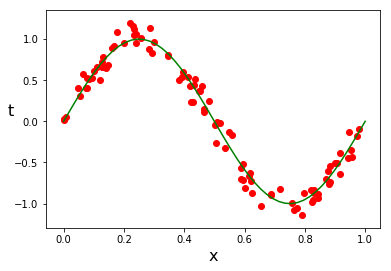

In [10]:
np.random.seed(seed)
N_test = 100 
x_test = np.random.rand(N_test)
t_test = np.sin(2*np.pi*x_test) + np.random.randn(N_test) * 0.1
plt.plot(x_sin, t_sin, c='green')
plt.scatter(x_test, t_test, c='red')
plt.xlabel('x', fontsize=16)
plt.ylabel('t', rotation=0, fontsize=16)
plt.show()

In [11]:
def root_mean_square_error(error, n_samples):
    return np.sqrt(2*error/n_samples)

In [12]:
# M=3
error = error_function(polynomial_function(x_test, w, M), t_test)
rms = root_mean_square_error(error, N_test)
rms

0.4857463954054708

In [13]:
def polynomial_function_prime(x, m):
    """dy/dw, same as vandermonde_matrix(x, m)"""
    return np.array([x**i for i in range(m+1)]).T  # shape (N, M)

In [14]:
def get_gradient(pred, t, x, m):
    """
    not good to use gradient descent to optimize polynomial
    https://stats.stackexchange.com/questions/350130/why-is-gradient-descent-so-bad-at-optimizing-polynomial-regression
    """
    return np.dot((pred-t), polynomial_function_prime(x, m), )

In [15]:
dE = get_gradient(t_hat, t, x, M)
dE

array([-1.16893952, -0.8515337 , -0.96879024, -1.26239455])

In [16]:
def train_phase(x, t, w, m, step=10, lr=0.1):
    """use gradient descent update"""
    errors = []
    for _ in range(step):
        t_hat = polynomial_function(x, w, m)
        error_value = error_function(t_hat, t)
        w -= lr * get_gradient(t_hat, t, x, m)
        errors.append(error_value)
    return w, errors

In [17]:
all_w = []
all_errors = []
for lr in [0.1, 0.01, 0.001, 0.0001]:
    np.random.seed(seed)
    w = np.random.normal(5, 10, size=(M+1))
    w, error = train_phase(x, t, w, M, step=100, lr=lr)
    all_w.append(w)
    all_errors.append(error)

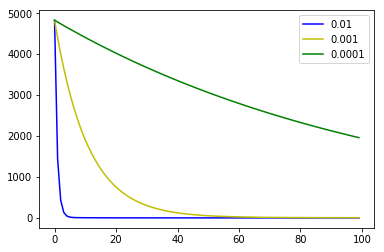

In [18]:
# to find optimal step for gradient descent
steps = np.arange(100)
for e, c, lr in zip(all_errors, ['r', 'b', 'y', 'g'], [0.1, 0.01, 0.001, 0.0001]):
    if e[-1] > 30000:
        continue
    plt.plot(steps, e, c=c, label=f"{lr}")
    plt.legend()
plt.show()

In [19]:
all_w[0]

array([1.49085249e+56, 8.59575725e+55, 6.33286096e+55, 5.11711745e+55])

In [20]:
P.polyfit(x, t, M)

array([ -0.06802217,  10.87247711, -32.38273035,  21.84125331])

Let's find optimal $M$. Think careful about derivatives

$$\begin{aligned}
\dfrac{\partial E}{\partial \mathbf{w}} &= \dfrac{\partial E}{\partial y} \dfrac{\partial y}{\partial \mathbf{w}} \\
&= \sum_{n=1}^N (y_n - t_n) \cdot \begin{bmatrix} 1 & x & x^2 & \cdots & x^M \end{bmatrix}
\end{aligned}$$

In [21]:
def get_rms_error(t_hat, t, n_sample, m):
    error = error_function(t_hat, t)
    rms = root_mean_square_error(error, n_sample)
    return rms

Train Error for M=0 is 687.8116 | rms_train: 0.6721 rms_test: 0.6929


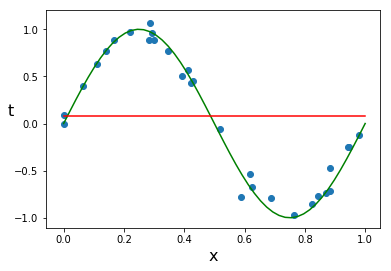

Train Error for M=1 is 380.3170 | rms_train: 0.4564 rms_test: 0.4389


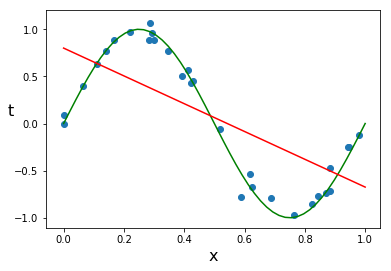

Train Error for M=2 is 308.4932 | rms_train: 0.4462 rms_test: 0.4373


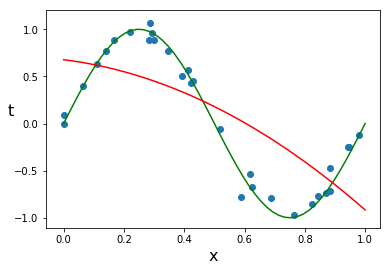

Train Error for M=3 is 316.7623 | rms_train: 0.4371 rms_test: 0.4246


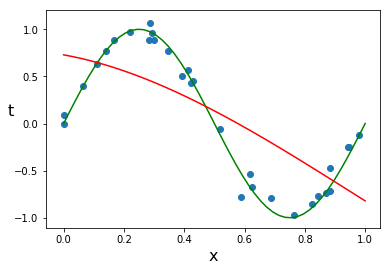

Train Error for M=4 is 320.8237 | rms_train: 0.4275 rms_test: 0.4133


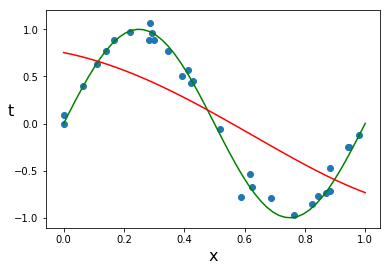

Train Error for M=5 is 344.0938 | rms_train: 0.4521 rms_test: 0.4417


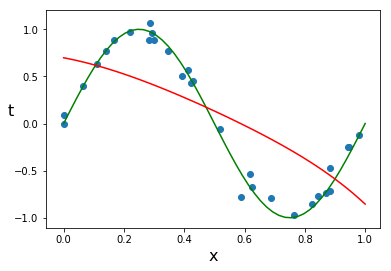

Train Error for M=6 is 351.7231 | rms_train: 0.4485 rms_test: 0.4381


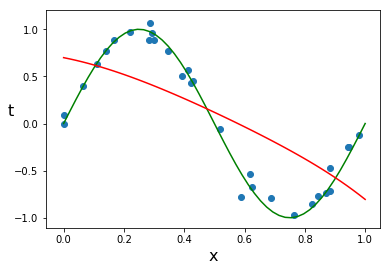

Train Error for M=7 is 395.1168 | rms_train: 0.4591 rms_test: 0.4488


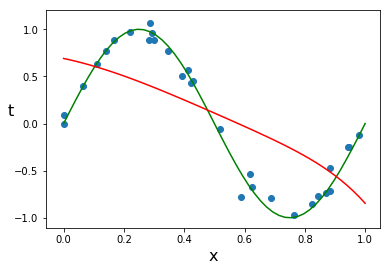

Train Error for M=8 is 452.0521 | rms_train: 0.4664 rms_test: 0.4554


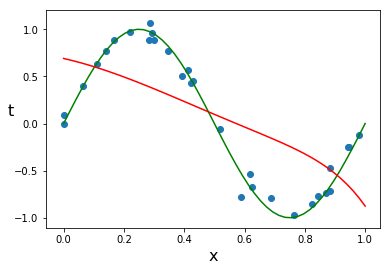

Train Error for M=9 is 327.1114 | rms_train: 0.4069 rms_test: 0.3969


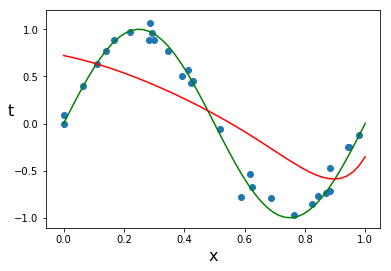

In [22]:
all_w = []
all_rms_train = []
all_rms_test = []
lr = 0.01

for m in range(10):
    np.random.seed(seed)
    w_raw = np.random.randn(m+1)
    optimal_w, train_error = train_phase(x, t, w_raw, m, step=100, lr=lr)
    
    t_hat = polynomial_function(x, optimal_w, m)
    t_hat_test = polynomial_function(x_test, optimal_w, m)
    
    rms_train = get_rms_error(t_hat, t, N, m)  # N=10
    rms_test = get_rms_error(t_hat_test, t_test, N_test, m)  # N_test = 100
    print(f"Train Error for M={m} is {np.sum(train_error):.4f} | rms_train: {rms_train:.4f} rms_test: {rms_test:.4f}")
    
    plt.plot(x_sin, t_sin, c="green")
    plt.plot(x_sin, polynomial_function(x_sin, optimal_w, m), c="red")
    plt.scatter(x, t)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('t', rotation=0, fontsize=16)
    plt.show()
    
    all_w.append(optimal_w)
    all_rms_train.append(rms_train)
    all_rms_test.append(rms_test)

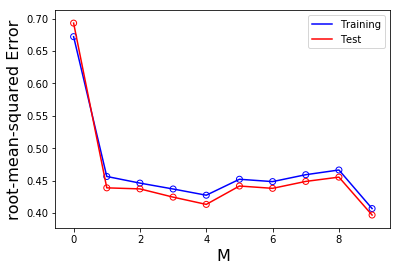

In [23]:
plt.scatter(np.arange(10), all_rms_train, facecolors='none', edgecolors='b')
plt.plot(np.arange(10), all_rms_train, c='b', label='Training')
plt.scatter(np.arange(len(all_rms_test)), all_rms_test, facecolors='none', edgecolors='r')
plt.plot(np.arange(len(all_rms_test)), all_rms_test, c='r', label='Test')
plt.legend()
plt.ylabel("root-mean-squared Error", fontsize=16)
plt.xlabel("M", fontsize=16)
plt.show()